## Imports and generic functions

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn_extra.cluster import KMedoids
import copy

In [3]:
red = (0.77, 0, 0.05) # (196, 0, 13)
blue = (0.12, 0.24, 1) # (31, 61, 255)
green = (0.31, 1, 0.34) # (79, 255, 87)
navyblue = (0, 0, 0.4) # (0, 0, 102)
black = (0, 0, 0)
white = (1, 1, 1)
cgreen = (0.57254902, 0.7254902 , 0.51372549) # (146, 185, 131)
cblue = (0.70196078, 0.83137255, 1) # (179, 212, 255)

top_domain = 600

def get_hydro_opt(d, lh, ls, lb, max_elec):
    # Get optimal adjustment at given balancing prices
    if ls > lh:
        return 0
    elif lb < lh:
        return max_elec
    else:
        return np.minimum(max_elec, np.maximum(0, d))

def import_consts(negative_prices=False):
    # import data and set constants
    all_data = pd.read_csv("./data/2022_data.csv")
    prices_B = np.maximum(all_data["UP"].to_numpy(),0)
    prices_S = np.maximum(all_data["DW"].to_numpy(),0)
    prices_F = np.maximum(all_data["forward_RE"].to_numpy(),0)
    prices_forecast = np.maximum(all_data["forward_FC"].to_numpy(), 0)

    max_elec = 10
    max_wind = 10
    nominal_wind = 10
    min_production = 50


    features = all_data.loc[:, ["Offshore DK2", "Offshore DK1", "Onshore DK2", "Onshore DK1", "production_FC"]]
    features["forward"] = prices_F
    features_red = all_data.loc[:, ["production_FC"]]
    features_red["forward"] = prices_F
    realized = all_data.loc[:, "production_RE"].to_numpy()
    realized *= nominal_wind

    # forecast_production = all_data.loc[:, "production_FC"].to_numpy() * nominal_wind
    fm_df = pd.read_csv("./results/fm.csv")
    forecast_production = fm_df.loc[:,"forecast_production"]

    price_H = 35.199999999999996
    penalty = np.quantile(prices_F, 0.95) # 95% quantile of forward price over entire dataset
    # penalty = 2 * price_H # Attempt at different penalties
    # penalty = np.max(prices_B) # Other attempt

    return (
        prices_B,
        prices_S,
        prices_F,
        prices_forecast,
        features,
        features_red,
        realized,
        price_H,
        max_elec,
        nominal_wind,
        penalty,
        min_production,
        forecast_production
    )

def get_forward_1(qF, features, t, fm):
    # Get forward market bid for model with 1 parameter per feature (General architecture)
    if fm:
        return np.sum([qF.iloc[0, i]*features[i][t] for i in range(len(features))]) + qF.iloc[0, -1]
    else:
        return np.sum([qF.iloc[0, i]*features.iloc[t, i] for i in range(len(features.columns))]) + qF.iloc[0, -1]

def get_forward_24(qF, features, t, fm):
    # Get forward market bid for model with 24 parameters per feature (Hourly architecture)
    hour_of_day = (t % 24)
    if fm:
        return np.sum([qF.iloc[hour_of_day, i]*features[i][t] for i in range(len(features))]) + qF.iloc[hour_of_day, -1]
    else:
        return np.sum([qF.iloc[hour_of_day, i]*features.iloc[t, i] for i in range(len(features.columns))]) + qF.iloc[hour_of_day, -1]


def get_hydro_1(qH, features, max_elec, t, fm):
    # Get hydrogen schedule for model with 1 parameter per feature (General architecture)
    if fm:
        return np.minimum(max_elec, np.maximum(0, np.sum([qH.iloc[0, i]*features[i][t] for i in range(len(features))]) + qH.iloc[0, -1]))
    else:
        return np.minimum(max_elec, np.maximum(0, np.sum([qH.iloc[0, i]*features.iloc[t, i] for i in range(len(features.columns))]) + qH.iloc[0, -1]))

def get_hydro_24(qH, features, max_elec, t, fm):
    # Get hydrogen schedule for model with 24 parameters per feature (Hourly architecture)
    hour_of_day = (t % 24) 
    if fm:
        return np.minimum(max_elec, np.maximum(0, np.sum([qH.iloc[hour_of_day, i]*features[i][t] for i in range(len(features))]) + qH.iloc[hour_of_day, -1]))
    else:
        return np.minimum(max_elec, np.maximum(0, np.sum([qH.iloc[hour_of_day, i]*features.iloc[t, i] for i in range(len(features.columns))]) + qH.iloc[hour_of_day, -1]))

def get_scaled_objs(list_of_results):
    # Get total revenue scaled to millions
    return [np.sum(result['obj'])/(1e6) for result in list_of_results]

def get_remaining_planned_hydro(df, features, max_elec, i):
    # Get the remaining amount of hydrogen scheduled in a given hour
    hour_of_day = (i % 24) 
    if (hour_of_day == 23):
        return 0
    remaining_hours = 23-hour_of_day
    return np.sum([get_hydro_24(df, features, max_elec, i+j)  for j in range(1, remaining_hours)])

#---------general and hourly evaluation loops

def test_initial_plan(df_f, df_h, idx_start, idx_end, general=False, fm=False, reduced_features=False):
    # Perform complete evaluation for general(general) and hourly models in a given time period : GA, HA
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    deficits = []
    surpluss = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0

    for i in range(idx_start, idx_end):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and i != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        if (general):
            if fm:
                forward_bid = get_forward_1(df_f, [forecast_production, prices_F], i, fm)
                h_prod = get_hydro_1(df_h, [forecast_production, prices_F], max_elec, i, fm)
            else:
                if reduced_features:
                    forward_bid = get_forward_1(df_f, features_red, i, fm)
                    h_prod = get_hydro_1(df_h, features_red, max_elec, i, fm)
                else:
                    forward_bid = get_forward_1(df_f, features, i, fm)
                    h_prod = get_hydro_1(df_h, features, max_elec, i, fm)
                    
        else:
            if fm:
                forward_bid = get_forward_24(df_f, [forecast_production, prices_F], i, fm)
                h_prod = get_hydro_24(df_h, [forecast_production, prices_F], max_elec, i, fm)
            else:
                if reduced_features:
                    forward_bid = get_forward_24(df_f, features_red, i, fm)
                    h_prod = get_hydro_24(df_h, features_red, max_elec, i, fm)
                else:
                    forward_bid = get_forward_24(df_f, features, i, fm)
                    h_prod = get_hydro_24(df_h, features, max_elec, i, fm)
                    
                
            
        forward_bid = np.minimum(forward_bid, max_elec)
        forward_bid = np.maximum(forward_bid, -max_elec)
        d = realized[i] - forward_bid

        h_prod = np.maximum(h_prod,0)
        h_prod = np.minimum(max_elec, h_prod)

        daily_count += h_prod

        settlementd = realized[i] - forward_bid - h_prod

        deficit = np.maximum(-settlementd, 0)
        surplus = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[i]
            + price_H * h_prod
            + surplus * prices_S[i]
            - deficit * prices_B[i]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        deficits.append(deficit)
        surpluss.append(surplus)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "deficit": deficits,
        "surplus": surpluss,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

def test_initial_plan_changing_qs(init_filename, cqs_filename, idx_start, idx_end, general=False, fm=False, reduced_features=False, weekly=False):
    # Perform complete evaluation for general(general) and hourly models with retraining in a given time period : GAR, HAR (not included in report)
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    deficits = []
    surpluss = []
    objs = []
    missing_productions = []
    missing_production = 0

    daily_count = 0

    df_retrained = pd.read_csv(init_filename)

    for i in range(idx_start, idx_end):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and i != idx_start:
            # print(f"Check daily count: ", daily_count)
            missing_production = np.maximum(0, min_production - daily_count)
            daily_count = 0

        j = i-idx_start
        if weekly:
            # if (j!= 0) and (j % 24 == 0):
            if (j!= 0) and (j % 168 == 0):
                df_retrained = pd.read_csv(f'{cqs_filename}_we{round(j/168,0):.0f}.csv')
        else:
            # if (j!= 0) and (j % 24 == 0):
            if (j!= 0) and (j % 720 == 0):
                df_retrained = pd.read_csv(f'{cqs_filename}_mo{round(j/720,0):.0f}.csv')


        if fm:
            df_f = df_retrained[[f"qF{i+1}" for i in range(3)]]
            df_h = df_retrained[[f"qH{i+1}" for i in range(3)]]
        else:
            if reduced_features:
                df_f = df_retrained[[f"qF{i+1}" for i in range(int(len(features_red.columns)+1))]]
                df_h = df_retrained[[f"qH{i+1}" for i in range(int(len(features_red.columns)+1))]]
            else:
                df_f = df_retrained[[f"qF{i+1}" for i in range(int(len(features.columns)+1))]]
                df_h = df_retrained[[f"qH{i+1}" for i in range(int(len(features.columns)+1))]]

            
        if (general):
            if fm:
                forward_bid = get_forward_1(df_f, [forecast_production, prices_F], i, fm)
                h_prod = get_hydro_1(df_h, [forecast_production, prices_F], max_elec, i, fm)
            else:
                if reduced_features:
                    forward_bid = get_forward_1(df_f, features_red, i, fm)
                    h_prod = get_hydro_1(df_h, features_red, max_elec, i, fm)
                else:
                    forward_bid = get_forward_1(df_f, features, i, fm)
                    h_prod = get_hydro_1(df_h, features, max_elec, i, fm)
                    
        else:
            if fm:
                forward_bid = get_forward_24(df_f, [forecast_production, prices_F], i, fm)
                h_prod = get_hydro_24(df_h, [forecast_production, prices_F], max_elec, i, fm)
            else:
                if reduced_features:
                    forward_bid = get_forward_24(df_f, features_red, i, fm)
                    h_prod = get_hydro_24(df_h, features_red, max_elec, i, fm)
                else:
                    forward_bid = get_forward_24(df_f, features, i, fm)
                    h_prod = get_hydro_24(df_h, features, max_elec, i, fm)
                    
        d = realized[i] - forward_bid

        forward_bid = np.minimum(forward_bid, max_elec)
        forward_bid = np.maximum(forward_bid, -max_elec)
        h_prod = np.maximum(h_prod,0)
        h_prod = np.minimum(max_elec, h_prod)
        daily_count += h_prod
        settlementd = realized[i] - forward_bid - h_prod

        deficit = np.maximum(-settlementd, 0)
        surplus = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[i]
            + price_H * h_prod
            + surplus * prices_S[i]
            - deficit * prices_B[i]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        deficits.append(deficit)
        surpluss.append(surplus)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "deficit": deficits,
        "surplus": surpluss,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

def test_fixed(forward, hydrogen, idx_start, idx_end):
    # Perform complete evaluation for "deterministic with all bids accepted" or "hindsight" models, where the forward bids and hydrogen schedules are fixed by an optimization problem
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    deficits = []
    surpluss = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0

    for i, t in enumerate(range(idx_start, idx_end)):
        hour_of_day = (t % 24) 
        if (hour_of_day == 0) and t != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        forward_bid = forward[i]
        d = realized[t] - forward_bid
        h_prod = hydrogen[i]

        settlementd = realized[t] - forward_bid - h_prod
        daily_count += h_prod

        deficit = np.maximum(-settlementd, 0)
        surplus = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_prod
            + surplus * prices_S[t]
            - deficit * prices_B[t]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        deficits.append(deficit)
        missing_productions.append(missing_production)
        missing_production = 0
        surpluss.append(surplus)
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "deficit": deficits,
        "surplus": surpluss,
        "missing_production": missing_productions,
        "obj": objs,
    }

    return results

def test_det(forward, hydrogen, idx_start, idx_end):
    # Perform complete evaluation for deterministic model with 5€/MW buffer in forward bids
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    deficits = []
    surpluss = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0

    for i, t in enumerate(range(idx_start, idx_end)):
        hour_of_day = (t % 24) 
        if (hour_of_day == 0) and t != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        if forward[i] >= 0:
            if prices_F[t] > (prices_forecast[t] - 5):
                forward_bid = forward[i]
            else:
                forward_bid = 0
        else:
            if prices_F[t] < (prices_forecast[t] + 5):
                forward_bid = forward[i]
            else:
                forward_bid = 0
        
        
        d = realized[t] - forward_bid
        h_prod = hydrogen[i]

        settlementd = realized[t] - forward_bid - h_prod
        daily_count += h_prod

        deficit = np.maximum(-settlementd, 0)
        surplus = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_prod
            + surplus * prices_S[t]
            - deficit * prices_B[t]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        deficits.append(deficit)
        missing_productions.append(missing_production)
        missing_production = 0
        surpluss.append(surplus)
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "deficit": deficits,
        "surplus": surpluss,
        "missing_production": missing_productions,
        "obj": objs,
    }

    return results


def test_price_domain(df, idx_start, idx_end, general=False, fm=False, reduced_features=False):
    # Perform complete evaluation for general(general) and hourly models with price domains in a given time period : GAPD, HAPD
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    deficits = []
    surpluss = []
    objs = []
    missing_productions = []
    missing_production = 0

    daily_count = 0
    for i in range(idx_start, idx_end):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and i != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0
            
        if prices_F[i] < price_H:
            domain = 1
        elif prices_F[i] < top_domain:
            domain = 2
        else:
            domain = 3

        if fm:
            df_f = df[[f"qF{domain}_{i+1}" for i in range(3)]]
            df_h = df[[f"qH{domain}_{i+1}" for i in range(3)]]
        else:
            if reduced_features:
                df_f = df[[f"qF{domain}_{i+1}" for i in range(int(len(features_red.columns)+1))]]
                df_h = df[[f"qH{domain}_{i+1}" for i in range(int(len(features_red.columns)+1))]]
            else:
                df_f = df[[f"qF{domain}_{i+1}" for i in range(int(len(features.columns)+1))]]
                df_h = df[[f"qH{domain}_{i+1}" for i in range(int(len(features.columns)+1))]]

        if (general):
            if fm:
                forward_bid = get_forward_1(df_f, [forecast_production, prices_F], i, fm)
                h_prod = get_hydro_1(df_h, [forecast_production, prices_F], max_elec, i, fm)
            else:
                if reduced_features:
                    forward_bid = get_forward_1(df_f, features_red, i, fm)
                    h_prod = get_hydro_1(df_h, features_red, max_elec, i, fm)
                else:
                    forward_bid = get_forward_1(df_f, features, i, fm)
                    h_prod = get_hydro_1(df_h, features, max_elec, i, fm)   
        else:
            if fm:
                forward_bid = get_forward_24(df_f, [forecast_production, prices_F], i, fm)
                h_prod = get_hydro_24(df_h, [forecast_production, prices_F], max_elec, i, fm)
            else:
                if reduced_features:
                    forward_bid = get_forward_24(df_f, features_red, i, fm)
                    h_prod = get_hydro_24(df_h, features_red, max_elec, i, fm)
                else:
                    forward_bid = get_forward_24(df_f, features, i, fm)
                    h_prod = get_hydro_24(df_h, features, max_elec, i, fm)
                    
            
        forward_bid = np.minimum(forward_bid, max_elec)
        forward_bid = np.maximum(forward_bid, -max_elec)
        d = realized[i] - forward_bid

        h_prod = np.maximum(h_prod,0)
        h_prod = np.minimum(max_elec, h_prod)
        daily_count += h_prod
        settlementd = realized[i] - forward_bid - h_prod

        deficit = np.maximum(-settlementd, 0)
        surplus = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[i]
            + price_H * h_prod
            + surplus * prices_S[i]
            - deficit * prices_B[i]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        deficits.append(deficit)
        surpluss.append(surplus)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "deficit": deficits,
        "surplus": surpluss,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

def test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end, general=False, fm=False, reduced_features=False, weekly=False):
    # Perform complete evaluation for general(general) and hourly models with price domains and retraining in a given time period : GAPDR, HAPDR
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    deficits = []
    surpluss = []
    objs = []
    missing_productions = []
    missing_production = 0

    daily_count = 0

    df_retrained = pd.read_csv(init_filename)

    for i in range(idx_start, idx_end):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and i != idx_start:
            # print(f"Check daily count: ", daily_count)
            missing_production = np.maximum(0, min_production - daily_count)
            daily_count = 0

        j = i-idx_start
        if weekly:
            # if (j!= 0) and (j % 24 == 0):
            if (j!= 0) and (j % 168 == 0):
                df_retrained = pd.read_csv(f'{cqs_filename}_we{round(j/168,0):.0f}.csv')
        else:
            # if (j!= 0) and (j % 24 == 0):
            if (j!= 0) and (j % 720 == 0):
                df_retrained = pd.read_csv(f'{cqs_filename}_mo{round(j/720,0):.0f}.csv')

        if prices_F[i] < price_H:
            domain = 1
        elif prices_F[i] < top_domain:
            domain = 2
        else:
            domain = 3

        if fm:
            df_f = df_retrained[[f"qF{domain}_{i+1}" for i in range(3)]]
            df_h = df_retrained[[f"qH{domain}_{i+1}" for i in range(3)]]
        else:
            if reduced_features:
                df_f = df_retrained[[f"qF{domain}_{i+1}" for i in range(int(len(features_red.columns)+1))]]
                df_h = df_retrained[[f"qH{domain}_{i+1}" for i in range(int(len(features_red.columns)+1))]]
            else:
                df_f = df_retrained[[f"qF{domain}_{i+1}" for i in range(int(len(features.columns)+1))]]
                df_h = df_retrained[[f"qH{domain}_{i+1}" for i in range(int(len(features.columns)+1))]]

            
        if (general):
            if fm:
                forward_bid = get_forward_1(df_f, [forecast_production, prices_F], i, fm)
                h_prod = get_hydro_1(df_h, [forecast_production, prices_F], max_elec, i, fm)
            else:
                if reduced_features:
                    forward_bid = get_forward_1(df_f, features_red, i, fm)
                    h_prod = get_hydro_1(df_h, features_red, max_elec, i, fm)
                else:
                    forward_bid = get_forward_1(df_f, features, i, fm)
                    h_prod = get_hydro_1(df_h, features, max_elec, i, fm)
                    
        else:
            if fm:
                forward_bid = get_forward_24(df_f, [forecast_production, prices_F], i, fm)
                h_prod = get_hydro_24(df_h, [forecast_production, prices_F], max_elec, i, fm)
            else:
                if reduced_features:
                    forward_bid = get_forward_24(df_f, features_red, i, fm)
                    h_prod = get_hydro_24(df_h, features_red, max_elec, i, fm)
                else:
                    forward_bid = get_forward_24(df_f, features, i, fm)
                    h_prod = get_hydro_24(df_h, features, max_elec, i, fm)
                    
        d = realized[i] - forward_bid

        forward_bid = np.minimum(forward_bid, max_elec)
        forward_bid = np.maximum(forward_bid, -max_elec)
        h_prod = np.maximum(h_prod,0)
        h_prod = np.minimum(max_elec, h_prod)
        daily_count += h_prod
        settlementd = realized[i] - forward_bid - h_prod

        deficit = np.maximum(-settlementd, 0)
        surplus = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[i]
            + price_H * h_prod
            + surplus * prices_S[i]
            - deficit * prices_B[i]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        deficits.append(deficit)
        surpluss.append(surplus)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "deficit": deficits,
        "surplus": surpluss,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results


def apply_upwards_adj(results_to_copy, idx_start, idx_end, printing=False):
    # Perform complete evaluation for upwards adjustment performed on a given model
    results = copy.deepcopy(results_to_copy) 
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    deficits = []
    surpluss = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0
    for i, t in enumerate(range(idx_start, idx_end)):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and t != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        forward_bid = results['forward_bid'][i]
        h_prod = results['h_prod'][i]

        d = realized[t] - forward_bid
        
        opt_h = get_hydro_opt(d, price_H, prices_S[t], prices_B[t], max_elec)

        hour_of_day = (i % 24) 
        remaining_hours = 23-hour_of_day
        if (hour_of_day == 23):
            remaining_planned = 0
        else:
            remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(1, remaining_hours)])

        if (opt_h > h_prod):
            if printing:
                print(f"i={i}, method 1: We changed from {h_prod} to {opt_h}")
            h_adj = opt_h
        else:
            h_adj = h_prod
        
        daily_count += h_adj
        settlementd = realized[t] - forward_bid - h_adj
        deficit = np.maximum(-settlementd, 0)
        surplus = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_adj
            + surplus * prices_S[t]
            - deficit * prices_B[t]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_adj)
        deficits.append(deficit)
        surpluss.append(surplus)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "deficit": deficits,
        "surplus": surpluss,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

def apply_up_and_dw_adj(results_to_copy, idx_start, idx_end, printing=False):
    # Perform complete evaluation for upwards and downwards adjustment performed on a given model
    results = copy.deepcopy(results_to_copy) 
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    deficits = []
    surpluss = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0
    for i, t in enumerate(range(idx_start, idx_end)):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and t != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        forward_bid = results['forward_bid'][i]
        h_prod = results['h_prod'][i]

        d = realized[t] - forward_bid
        
        opt_h = get_hydro_opt(d, price_H, prices_S[t], prices_B[t], max_elec)
        
        if (opt_h > h_prod):
            if printing:
                print(f"i={i}, method 1: We changed from {h_prod} to {opt_h}")
            h_adj = opt_h
        # elif (prices_S[t] > penalty):
        #     h_adj = 0
        else:
            remaining_hours = 23-hour_of_day
            if (hour_of_day == 23):
                remaining_planned = 0
            else:
                # remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(1, remaining_hours)])
                remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(remaining_hours+1)])
            surplus = daily_count + remaining_planned - min_production
            wanted = h_prod - opt_h
            if surplus >= wanted:
                h_adj = opt_h
            else:
                h_adj = np.minimum(np.maximum(h_prod - surplus, 0), max_elec)
                if printing:
                    print(f"i={i}, t={t}, hod={hour_of_day}")
                    print(f"planned={remaining_planned}, produced={daily_count}")
                    print(f"surplus={surplus}, wanted={wanted}")
                    print(f"Original prod: {h_prod}, Resulting prod: {h_adj}")
        
        daily_count += h_adj
        settlementd = realized[t] - forward_bid - h_adj
        deficit = np.maximum(-settlementd, 0)
        surplus = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_adj
            + surplus * prices_S[t]
            - deficit * prices_B[t]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_adj)
        deficits.append(deficit)
        surpluss.append(surplus)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "deficit": deficits,
        "surplus": surpluss,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

def apply_risky_policy(results_to_copy, idx_start, idx_end, printing=False):
    # Perform complete evaluation for postponing adjustment performed on a given model
    results = copy.deepcopy(results_to_copy) 
    (prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

    forward_bids = []
    ds = []
    h_prods = []
    deficits = []
    surpluss = []
    objs = []
    missing_productions = []
    missing_production = 0
    daily_count = 0
    for i, t in enumerate(range(idx_start, idx_end)):
        hour_of_day = (i % 24) 
        if (hour_of_day == 0) and t != idx_start:
            missing_production = np.maximum(min_production - daily_count, 0)
            daily_count = 0

        forward_bid = results['forward_bid'][i]
        h_prod = results['h_prod'][i]

        d = realized[t] - forward_bid
        
        opt_h = get_hydro_opt(d, price_H, prices_S[t], prices_B[t], max_elec)

        hour_of_day = (i % 24) 
        remaining_hours = 23-hour_of_day
        if (hour_of_day == 23):
            remaining_planned = 0
        else:
            remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(1, remaining_hours)])

        if (opt_h > h_prod):
            h_prod = opt_h
        else:
            remaining_hours = 23-hour_of_day
            if (hour_of_day == 23):
                remaining_planned = 0
            else:
                remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(1, remaining_hours)])
            surplus = daily_count + remaining_planned - min_production
            wanted = h_prod - opt_h
            if surplus >= wanted or hour_of_day == 23:
                h_adj = opt_h
            else:
                # Postpone production to later time with low forward price
                forward_prices_remaining = copy.deepcopy(prices_F[t:t+(23-hour_of_day)])
                while wanted > 0:
                    preffered_idx = np.argmin(forward_prices_remaining)
                    price_to_remove = forward_prices_remaining[preffered_idx]
                    if (prices_B[t] < price_to_remove):
                        # If it is cheaper to buy now than we expect it to be later, don't change
                        h_adj = np.minimum(np.maximum(h_prod - surplus, 0), max_elec)
                        break
                    else:
                        free_turn_up = max_elec - results['h_prod'][i+preffered_idx]
                        if (free_turn_up >= wanted):
                            results['h_prod'][i+preffered_idx] += wanted
                            h_adj = opt_h
                            break
                        else:
                            # Turn up as much as much as possible at cheaper later hour
                            results['h_prod'][i+preffered_idx] = max_elec
                            # Reduce the amount we still want accordingly
                            wanted -= free_turn_up
                            # Make the later price unused
                            forward_prices_remaining[preffered_idx] = 9999
                            # Recalculate how much we have in surplus (larger now because we turned up)
                            if (hour_of_day == 23):
                                remaining_planned = 0
                            else:
                                remaining_planned = np.sum([results['h_prod'][i+j]  for j in range(1, remaining_hours)])
                            surplus = daily_count + remaining_planned - min_production


        daily_count += h_prod
        settlementd = realized[t] - forward_bid - h_prod
        deficit = np.maximum(-settlementd, 0)
        surplus = np.maximum(settlementd, 0)
        obj = (
            forward_bid * prices_F[t]
            + price_H * h_prod
            + surplus * prices_S[t]
            - deficit * prices_B[t]
            - missing_production * penalty
        )

        forward_bids.append(forward_bid)
        ds.append(d)
        h_prods.append(h_prod)
        deficits.append(deficit)
        surpluss.append(surplus)
        missing_productions.append(missing_production)
        missing_production = 0
        objs.append(obj)

    results = {
        "forward_bid": forward_bids,
        "d": ds,
        "h_prod": h_prods,
        "deficit": deficits,
        "surplus": surpluss,
        "missing_production": missing_productions,
        "obj": objs,
    }
    return results

(prices_B,prices_S,prices_F,prices_forecast,features,features_red,realized,price_H,max_elec,nominal_wind,penalty,min_production, forecast_production) = import_consts()

month = 30*24

In [4]:
idx_start = len(prices_F) - 2*month
idx_end = len(prices_F)
idx_final = len(prices_F)


## Testing the models

#### Deterministic and optimal

In [ ]:
#-----------Deterministic
df_det = pd.read_csv("./results/2022/deterministic.csv")

result_det = test_fixed(df_det.loc[:, 'forward bid'], df_det.loc[:, 'hydrogen production'], idx_start, idx_end)
print(f"Deterministic model: {np.sum(result_det['obj'])}")
df_det = pd.read_csv("./results/2022/deterministic.csv")
result_det_strict = test_det(df_det.loc[:, 'forward bid'], df_det.loc[:, 'hydrogen production'], idx_start+month, idx_end)
print(f": Deterministic model +/- : {np.sum(result_det_strict['obj'])}")

#-----------Optimal
df_opt = pd.read_csv("./results/2022/optimal_everything.csv")
result_opt = test_fixed(df_opt.loc[:, 'forward bid'], df_opt.loc[:, 'hydrogen production'], idx_start+month, idx_end)
print(f": Optimal everything: {np.sum(result_opt['obj'])}")


#### General models

##### General

In [315]:

#--------------------------GENERAL-----------------

def test_general(model_name, fm=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    for i in range(3):
        df = pd.read_csv(f"./results/2022/comparing_architecture/{model_name}_mo{i+1}.csv")
        df_f = df[[f"qF{i+1}" for i in range(int(len(df.columns)/2))]]
        df_h = df[[f"qH{i+1}" for i in range(int(len(df.columns)/2))]]
        tester_results = test_initial_plan(df_f, df_h, idx_start, idx_end, True, fm, reduced_features)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results

# GENERAL For all features
results_g_all = test_general("GENERAL")

# GENERAL Only forecast and price features
results_g_rf = test_general("GENERAL_rf", False, True)

# GENERAL Forecast model
results_g_fm = test_general("GENERAL_fm", True)



Testing model  GENERAL_fp
1 months training: 408251.8880913304
2 months training: 420825.59296617634
3 months training: 425336.6193145495

Testing model  GENERAL_forecast_model
1 months training: 330864.75005933177
2 months training: 343607.51526726986
3 months training: 332562.89194946346


##### General PD

In [ ]:

# #--------------------------general_PD-----------------

def test_general_pd(model_name, fm=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    for i in range(4):
        df = pd.read_csv(f"./results/2022/pricedomains/{model_name}_mo{i+1}.csv")
        tester_results = test_price_domain(df, idx_start+month, idx_end, True, fm, reduced_features)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results

results_g_all_PD = test_general_pd("general_PD")
results_g_rf_PD = test_general_pd("general_rf_PD", False, True)
results_g_fm_PD = test_general_pd("general_fm_PD", True)


##### General pd Retraining

In [ ]:
#--------------------------general_pricedomain_RETRAINING-----------------

def test_general_pd_retraining(init_filename, model_name, fm=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    for i in range(3):
        cqs_filename = (f"./results/2022/changing_qs_general/{i+1}_month_training/{model_name}")
        tester_results = test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end, True, fm, reduced_features)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results

# general_pricedomain_RETRAINING For all features
s_all_pd_init = f"./results/2022/pricedomains/general_PD_mo1.csv"
results_g_all_PD_retrained = test_general_pd_retraining(s_all_pd_init, "general_pricedomain_RETRAINING")

# general_pricedomain_RETRAINING Only forecast and price features
s_rf_pd_init = f"./results/2022/pricedomains/general_rf_PD_mo1.csv"
results_g_rf_PD_retrained = test_general_pd_retraining(s_rf_pd_init, "general_rf_pricedomain_RETRAINING", False, True)

# general_pricedomain_RETRAINING For forecast model
s_fm_pd_init = f"./results/2022/pricedomains/general_fm_PD_mo1.csv"
results_g_fm_PD_retrained = test_general_pd_retraining(s_fm_pd_init, "general_forecasted_fm_pricedomain_RETRAINING", True)


#### Hourly models

##### Hourly

In [319]:

#--------------------------HOURLY-----------------

def test_hourly(model_name, fm=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    for i in range(3):
        df = pd.read_csv(f"./results/2022/comparing_architecture/{model_name}_mo{i+1}.csv")
        df_f = df[[f"qF{i+1}" for i in range(int(len(df.columns)/2))]]
        df_h = df[[f"qH{i+1}" for i in range(int(len(df.columns)/2))]]
        tester_results = test_initial_plan(df_f, df_h, idx_start, idx_end, False, fm, reduced_features)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results

# HOURLY For all features
results_h_all = test_hourly("HOURLY")

# HOURLY Only forecast and price features
results_h_rf = test_hourly("HOURLY_rf", False, True)

# HOURLY Forecast model
results_h_fm = test_hourly("HOURLY_fm", True)



Testing model  HOURLY_fp
1 months training: 562638.8215305872
2 months training: 608706.0251155213
3 months training: 616255.1525278414

Testing model  HOURLY_forecast_model
1 months training: 556881.3005808952
2 months training: 610070.385801447
3 months training: 615769.1215054411


##### Hourly PD

In [ ]:

#--------------------------hourly_PD-----------------


def test_hourly_pd(model_name, fm=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    for i in range(4):
        df = pd.read_csv(f"./results/2022/pricedomains/{model_name}_mo{i+1}.csv")
        tester_results = test_price_domain(df, idx_start+month, idx_end, False, fm, reduced_features)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results

# hourly_PD all
results_h_all_PD = test_hourly_pd("hourly_PD")

# hourly_PD FP
results_h_rf_PD = test_hourly_pd("hourly_rf_PD", False, True)

# hourly_PD Forecast model
results_h_fm_PD = test_hourly_pd("hourly_fm_PD", True)

In [21]:
np.mean(prices_F[4*month:])

360.91614583333336

##### Hourly retraining

In [ ]:

def test_hourly_retrained(init_filename, model_name, fm=False, reduced_features=False, weekly=True):
    results = []
    print("\nTesting monthly model ", model_name)
    for i in range(3):
        cqs_filename = (f"./results/2022/changing_qs_hourly/{i+1}_month_training/{model_name}")
        tester_results = test_initial_plan_changing_qs(init_filename, cqs_filename, idx_start, idx_end, False, fm, reduced_features, weekly)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results

m_rf_init = f"./results/2022/comparing_architecture/hourly_rf_mo3.csv"
results_h_rf_retrained = test_hourly_retrained(m_rf_init, "hourly_rf_RETRAINING", False, True)

m_fm_init = f"./results/2022/comparing_architecture/HOURLY_fm_mo3.csv"
results_h_fm_retrained = test_hourly_retrained(m_fm_init, "hourly_fm_RETRAINING", True)


##### Hourly pd Oracle

In [ ]:

#--------------------------hourly_pricedomain_ORACLE-----------------

def test_hourly_pd_oracle(model_name, fm=False, reduced_features=False):
    results = []
    print("\nTesting model ", model_name)
    df = pd.read_csv(f"./results/2022/pricedomains/{model_name}.csv")
    tester_results = test_price_domain(df, idx_start, idx_end, False, fm, reduced_features)
    results.append(tester_results)
    print(f"Result: {np.sum(tester_results['obj'])}")
    return results

# hourly_PD For all features - result was 
results_h_all_pd_ORACLE = test_hourly_pd_oracle("hourly_pricedomain_ORACLE")

# hourly_PD Only forecast and price features - result was 
results_h_rf_pd_ORACLE = test_hourly_pd_oracle("hourly_rf_pricedomain_ORACLE", False, True)

# hourly_PD Forecast model - result was 
results_h_fm_pd_ORACLE = test_hourly_pd_oracle("hourly_fm_pricedomain_ORACLE", True)


##### Hourly pd Retraining

In [ ]:
#--------------------------hourly_pricedomain_RETRAINING-----------------

def test_hourly_pd_retraining(init_filename, model_name, fm=False, reduced_features=False):
    results = []
    print("\nTesting monthly model ", model_name)
    for i in range(3):
        cqs_filename = (f"./results/2022/changing_qs_hourly/{i+1}_month_training/{model_name}")
        tester_results = test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end, False, fm, reduced_features)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results


def test_hourly_pd_retraining_weekly(init_filename, model_name, fm=False, reduced_features=False):
    results = []
    print("\nTesting weekly model ", model_name)
    for i in range(3):
        cqs_filename = (f"./results/2022/changing_qs_hourly/{i+1}_month_training/{model_name}")
        tester_results = test_price_domain_changing_qs(init_filename, cqs_filename, idx_start, idx_end, False, fm, reduced_features, True)
        results.append(tester_results)
        print(f"{i+1} months training: {np.sum(tester_results['obj'])}")
    return results
# # general_pricedomain_RETRAINING For all features - best was 
# m_all_pd_init = f"./results/2022/pricedomains/hourly_PD_mo1.csv"
# results_h_all_PD_retrained = test_hourly_pd_retraining(m_all_pd_init, "hourly_pricedomain_RETRAINING")

# # general_pricedomain_RETRAINING Only forecast and price features - best was 
# m_rf_pd_init = f"./results/2022/pricedomains/hourly_rf_PD_mo3.csv"
# results_h_rf_PD_retrained = test_hourly_pd_retraining(m_rf_pd_init, "hourly_rf_pricedomain_RETRAINING", False, True)

# # # general_pricedomain_RETRAINING Forecast model - best was 
# m_fm_pd_init = f"./results/2022/pricedomains/hourly_fm_PD_mo3.csv"
# results_h_fm_PD_retrained = test_hourly_pd_retraining(m_fm_pd_init, "hourly_fm_pricedomain_RETRAINING", True)

# general_pricedomain_RETRAINING Only forecast and price features - best was 
m_rf_pd_init = f"./results/2022/pricedomains/hourly_rf_PD_mo3.csv"
results_h_rf_PD_retrained = test_hourly_pd_retraining_weekly(m_rf_pd_init, "hourly_rf_pricedomain_RETRAINING", False, True)

# # general_pricedomain_RETRAINING Forecast model - best was 
m_fm_pd_init = f"./results/2022/pricedomains/hourly_fm_PD_mo3.csv"
results_h_fm_PD_retrained = test_hourly_pd_retraining_weekly(m_fm_pd_init, "hourly_fm_pricedomain_RETRAINING", True)


# # HIGH penalty 
# m_fm_pd_init = f"./results/2022/pricedomains/hourly_fm_PD_mo3.csv"
# results_h_fm_PD_retrained_highpen = test_hourly_pd_retraining_weekly(m_fm_pd_init, "hourly_fm_pricedomain_RETRAINING", True)


In [ ]:
def printstuff(r1, r2, trange, maxcount=10):
    # To perform detailed investigations of model outputs
    counter = 0
    for i in trange:
        if counter > maxcount:
            break
        if round(r2['obj'][i], 0) < round(r1['obj'][i], 0):
            counter += 1
            t = i+idx_start
            print(f"\ni={i}, fp={prices_F[t]}, sp={prices_S[t]}, bp={prices_B[t]}, realized={realized[t]}, opt_h={get_hydro_opt(realized[t]-r1['forward_bid'][i], price_H, prices_S[t], prices_B[t], max_elec)}")
            print(f"ori: {r1['obj'][i]:.2f}, fb={r1['forward_bid'][i]:.2f}, hprod={r1['h_prod'][i]:.2f}, surplus={r1['surplus'][i]:.2f}, deficit={r1['deficit'][i]:.2f}, missing={r1['missing_production'][i]:.2f}")
            print(f"should-be-better: {r2['obj'][i]:.2f}, fb={r2['forward_bid'][i]:.2f}, hprod={r2['h_prod'][i]:.2f}, surplus={r2['surplus'][i]:.2f}, deficit={r2['deficit'][i]:.2f}, missing={r2['missing_production'][i]:.2f}")

# Test on when model HAPD-FM-2 was different from optimal as example:
# printstuff(results_h_fm_PD_retrained[1], result_opt, range(idx_end-idx_start))


#### Adjustment

In [246]:
def adjust(res):
    # Apply all 3 kinds of adjustment to a model
    res_up = apply_upwards_adj(res, idx_start, idx_end)
    res_up_dw = apply_up_and_dw_adj(res, idx_start, idx_end)
    res_pp = apply_risky_policy(res, idx_start, idx_end)
    return res_up, res_up_dw, res_pp

##### Deterministic adjustment

In [157]:
det_up = apply_upwards_adj(result_det, idx_start, idx_end)
det_up_dw = apply_up_and_dw_adj(result_det, idx_start, idx_end)
det_pp = apply_risky_policy(result_det, idx_start, idx_end)
print("Original: ", np.sum(result_det['obj']))
print("Upwards adj: ", np.sum(det_up['obj']))
print("Up + dw adj: ", np.sum(det_up_dw['obj']))
print("Postponing adj: ", np.sum(det_pp['obj']))

Original:  497157.51979968895
Upwards adj:  498417.51979968895
Up + dw adj:  575493.3683104299
Postponing adj:  231968.3280949185


##### General architecture adjustment (GAPD-FM-3)

In [156]:
other_up = apply_upwards_adj(results_g_fm_PD[2], idx_start, idx_end)
other_up_dw = apply_up_and_dw_adj(results_g_fm_PD[2], idx_start, idx_end)
other_pp = apply_risky_policy(results_g_fm_PD[2], idx_start, idx_end)
print("Original: ", np.sum(results_g_fm_PD[2]['obj']))
print("Upwards adj: ", np.sum(other_up['obj']))
print("Up + dw adj: ", np.sum(other_up_dw['obj']))
print("Postponing adj: ", np.sum(other_pp['obj']))

Original:  402425.26201854437
Upwards adj:  403339.8939402129
Up + dw adj:  488049.8555924696
Postponing adj:  200569.93087797402


##### Hourly architecture adjustment (HAPD-FM-3)

In [242]:
best_up = apply_upwards_adj(results_h_fm_PD_retrained[2], idx_start, idx_end)
best_up_dw = apply_up_and_dw_adj(results_h_fm_PD_retrained[2], idx_start, idx_end)
best_pp = apply_risky_policy(results_h_fm_PD_retrained[2], idx_start, idx_end)
print("Original: ", np.sum(results_h_fm_PD_retrained[2]['obj']))
print("Upwards adj: ", np.sum(best_up['obj']))
print("Up + dw adj: ", np.sum(best_up_dw['obj']))
print("Postponing adj: ", np.sum(best_pp['obj']))

Original:  668119.0478225516
Upwards adj:  669210.4730539926
Up + dw adj:  637669.0787641337
Postponing adj:  512440.655728754


#### Plots

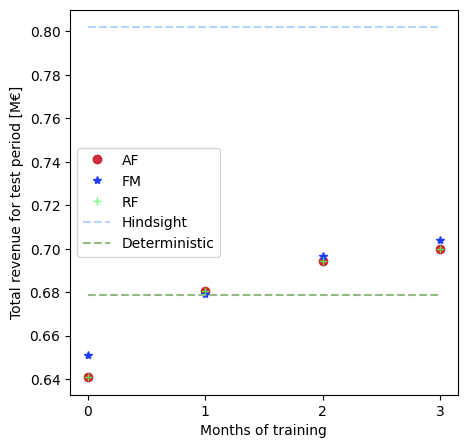

In [27]:
#-----------------------HAPD results
factor_dw = 1e6
all_objs = [np.sum(res['obj'])/factor_dw for res in results_h_all_PD]
fp_objs = [np.sum(res['obj'])/factor_dw for res in results_h_rf_PD]
model_objs = [np.sum(res['obj'])/factor_dw for res in results_h_fm_PD]

optimals = [np.sum(result_opt['obj'])/factor_dw for _ in range(4)]
deterministics = [np.sum(result_det_strict['obj'])/factor_dw for _ in range(4)]


xs = range(4)
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(xs, fp_objs, 'o', color=red, alpha=0.8, label="AF")
ax.plot(xs, model_objs, '*', color=blue, label="FM")
ax.plot(xs, fp_objs, '+', color=green, alpha=0.8, label="RF")
ax.plot(xs, optimals, '--', color=cblue, label="Hindsight")
ax.plot(xs, deterministics, '--', color=cgreen, label="Deterministic")
ax.legend()
ax.set_xlabel("Months of training")
ax.set_ylabel("Total revenue for test period [M€]")
# ax.set_ylim(0, 1)
ax.set_xticks(xs)
fig.savefig("./pdfs/2022_results.pdf")

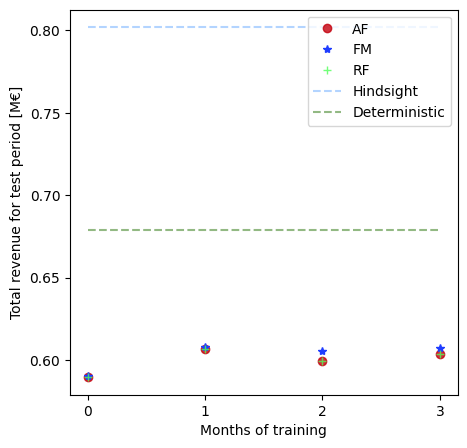

In [8]:
#-------------------------GAPD results
factor_dw = 1e6
all_objs = [np.sum(res['obj'])/factor_dw for res in results_g_all_PD]
fp_objs = [np.sum(res['obj'])/factor_dw for res in results_g_rf_PD]
model_objs = [np.sum(res['obj'])/factor_dw for res in results_g_fm_PD]

optimals = [np.sum(result_opt['obj'])/factor_dw for _ in range(4)]
deterministics = [np.sum(result_det_strict['obj'])/factor_dw for _ in range(4)]


xs = range(4)
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(xs, fp_objs, 'o', color=red, alpha=0.8, label="AF")
ax.plot(xs, model_objs, '*', color=blue, label="FM")
ax.plot(xs, fp_objs, '+', color=green, alpha=0.8, label="RF")
ax.plot(xs, optimals, '--', color=cblue, label="Hindsight")
ax.plot(xs, deterministics, '--', color=cgreen, label="Deterministic")
ax.legend()
ax.set_xlabel("Months of training")
ax.set_ylabel("Total revenue for test period [M€]")
# ax.set_ylim(0, 1)
ax.set_xticks(xs)
fig.savefig("./pdfs/2022_results_general.pdf")

C:\Users\emilh\AppData\Local\Temp\ipykernel_6340\2107365894.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=45)
C:\Users\emilh\AppData\Local\Temp\ipykernel_6340\2107365894.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


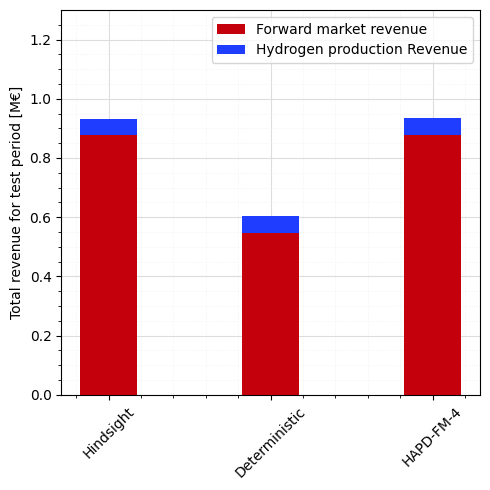

In [35]:
fig, ax = plt.subplots(figsize=(5,5))
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()
ax.set_axisbelow(True)
values = np.array([
    np.sum([result_opt['forward_bid'][i]*prices_F[t] for i,t in enumerate(range(idx_end-month, idx_end)) if result_opt['forward_bid'][i] > 0]),
    np.sum([result_det_strict['forward_bid'][i]*prices_F[t] for i,t in enumerate(range(idx_end-month, idx_end)) if result_det_strict['forward_bid'][i] > 0]),
    np.sum([results_h_fm_PD[3]['forward_bid'][i]*prices_F[t] for i,t in enumerate(range(idx_end-month, idx_end)) if results_h_fm_PD[3]['forward_bid'][i] > 0]),
])

hydrogens = np.array([
    np.sum([result_opt['h_prod'][i]*price_H for i,t in enumerate(range(idx_end-month, idx_end))]),
    np.sum([result_det_strict['h_prod'][i]*price_H for i,t in enumerate(range(idx_end-month, idx_end))]),
    np.sum([results_h_fm_PD[3]['h_prod'][i]*price_H for i,t in enumerate(range(idx_end-month, idx_end))]),
])
values *= 1/1e6
hydrogens *= 1/1e6
width = 0.35
xlabels = ["Hindsight", "Deterministic", "HAPD-FM-4"]
xs = range(len(values))
ax.bar(xs, values, width, color=red, label="Forward market revenue")
ax.bar(xs, hydrogens, width, bottom=values, color=blue, label="Hydrogen production Revenue")
# if plot_penalties:
#     ax.bar(xs, penalties, width, bottom=values, color=blue, label="Penalty Loss")
# if plot_adjustments:
#     ax.bar(xs, adjustments, width, bottom=values, color=blue, label="Adjustment Revenue")
ax.set_xticklabels(xlabels, rotation=45)
ax.set_xticks(xs)
ax.set_ylabel("Total revenue for test period [M€]")
ax.set_ylim(0, 1.3)
fig.show()
fig.tight_layout()
ax.legend()
fig.savefig("./pdfs/rev_dist_2022.pdf")

In [ ]:
#---------------Overview results plot
results_to_plot = [
    [results_g_rf, results_g_fm],
    [results_h_rf, results_h_fm],
    [results_g_rf_PD, results_g_fm_PD],
    [results_h_rf_PD, results_h_fm_PD],
    [results_g_rf_PD_retrained, results_g_fm_PD_retrained],
    [results_h_rf_PD_retrained, results_h_fm_PD_retrained]
]

plot_titles = [
    "General",
    "Hourly",
    "General w. price domains",
    "Hourly w. price domains",
    "General w. PD - Retrained monthly",
    "Hourly w. PD - Retrained monthly",
]

fig, axs = plt.subplots(2,3, figsize=(15,10))
xs = range(1,4)
optimals = [np.sum(result_opt['obj'])/(1e6) for _ in xs]
deterministics = [np.sum(result_det['obj'])/(1e6) for _ in xs]
for i, result_list in enumerate(results_to_plot):
    idx2 = int(np.floor((i/2)%3))
    idx1 = int(i%2)
    # print(f"idx1: {idx1}, idx2: {idx2}")
    # axs[idx1, idx2].plot(xs, get_scaled_objs(result_list[0]), color=red, label="All features")
    axs[idx1, idx2].plot(xs, get_scaled_objs(result_list[0]), 'o', color=blue, alpha=0.8, label="Reduced feature-vector")
    axs[idx1, idx2].plot(xs, get_scaled_objs(result_list[1]), '*', color=green, label="Forecast model")
    axs[idx1, idx2].plot(xs, optimals, '--k', label="Optimal")
    axs[idx1, idx2].plot(xs, deterministics, '--y', label="Deterministic")
    axs[idx1, idx2].set_title(plot_titles[i])
    axs[idx1, idx2].legend()
    axs[idx1, idx2].set_xlabel("Months of training")
    axs[idx1, idx2].set_ylabel("Total revenue for test period [M€]")
    axs[idx1, idx2].set_ylim(0, 1)
    axs[idx1, idx2].set_xticks(xs)


# axs[1, 1].plot(xs, results_h_all_PD[0], 'o', color=red, label="All features")
fig.tight_layout()
fig.savefig("2022_results.pdf")



Best is 56.26 % better than General Architecture


C:\Users\emilh\AppData\Local\Temp\ipykernel_11592\3359083918.py:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=45)
C:\Users\emilh\AppData\Local\Temp\ipykernel_11592\3359083918.py:79: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


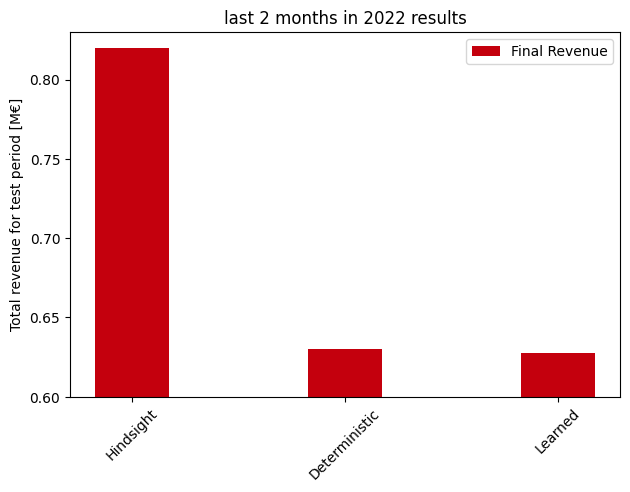

In [461]:
#-------------------Final results 2022 - HAPD-FM-3
best_res = results_h_fm_PD_retrained[2]

strict_det = True
plot_penalties = False
plot_adjustments = False

testname = "General Architecture"
# testname = "Reduced features"
# testname = "No retraining"
# testname = "No price domains"


def result_plot():
    if testname == "General Architecture":
        other_res = results_g_fm_PD_retrained[2] # architecture
    elif testname == "Reduced features":
        other_res = results_h_rf_PD_retrained[2] # features
    elif testname == "No retraining":
        other_res = results_h_fm_PD[2] # retraining
    elif testname == "No price domains":
        other_res = results_h_fm_retrained[2] # price domains

    # other_res = results_h_fm_PD_retrained_highpen[2]

    if strict_det:
        det_res = result_det_strict
    else:
        det_res = result_det


    det_up, det_up_dw, det_pp = adjust(det_res)
    best_up, best_up_dw, best_pp = adjust(best_res)
    other_up, other_up_dw, other_pp = adjust(other_res)

    other = results_h_fm[2]
    # xlabels = ["Hindsight", "Deterministic", "Learned", testname]
    xlabels = ["Hindsight", "Deterministic", "Learned"]
    # xlabels = ["Hindsight", "Deterministic", "95% quantile penalty", "Max penalty"]
    values = np.array([
        np.sum(result_opt['obj']),
        np.sum(det_res['obj']),
        np.sum(best_res['obj']),
        # np.sum(other_res['obj'])
    ])


    penalties = np.array([
        0, 0, 
        np.sum(best_res['missing_production'])*penalty,
        np.sum(other_res['missing_production'])*penalty
        # np.sum(other_res['missing_production'])*np.max(prices_B)
    ])

    adjustments = np.array([
        0,
        np.sum(det_up_dw['obj'])-np.sum(det_res['obj']),
        np.sum(best_up_dw['obj'])-np.sum(best_res['obj']),
        np.sum(other_up_dw['obj'])-np.sum(other_res['obj'])
    ])

    values *= 1/1e6
    penalties *= 1/1e6
    adjustments *= 1/1e6

    xs = range(len(values))
    width = 0.35
    fig, ax = plt.subplots()
    ax.bar(xs, values, width, color=red, label="Final Revenue")
    if plot_penalties:
        ax.bar(xs, penalties, width, bottom=values, color=blue, label="Penalty Loss")
    if plot_adjustments:
        ax.bar(xs, adjustments, width, bottom=values, color=blue, label="Adjustment Revenue")
    ax.set_xticklabels(xlabels, rotation=45)
    ax.set_xticks(xs)
    ax.set_ylabel("Total revenue for test period [M€]")
    ax.set_ylim(0.6, 0.83)
    fig.show()
    fig.tight_layout()
    ax.legend()
    ax.set_title("last 2 months in 2022 results")
    print("\n")
    print(f"Best is {(np.sum(best_res['obj'])-np.sum(other_res['obj']))/(np.sum(other_res['obj']))*100:.2f} % better than {testname}")
    return fig, ax

fig, ax = result_plot()

# fig.savefig("Impact_of_penalties.pdf")

C:\Users\emilh\AppData\Local\Temp\ipykernel_6340\1711187031.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=45)
C:\Users\emilh\AppData\Local\Temp\ipykernel_6340\1711187031.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


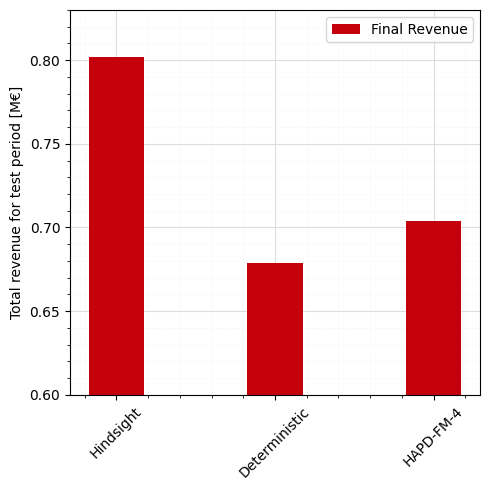

In [18]:
# -----------HAPD-FM-4 results plot
width = 0.35
fig, ax = plt.subplots(figsize=(5,5))
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()
ax.set_axisbelow(True)
values = np.array([
    np.sum(result_opt['obj']),
    np.sum(result_det_strict['obj']),
    np.sum(results_h_fm_PD[4]['obj'])
])
values *= 1/1e6
xlabels = ["Hindsight", "Deterministic", "HAPD-FM-4"]
xs = range(len(values))
ax.bar(xs, values, width, color=red, label="Final Revenue")
# if plot_penalties:
#     ax.bar(xs, penalties, width, bottom=values, color=blue, label="Penalty Loss")
# if plot_adjustments:
#     ax.bar(xs, adjustments, width, bottom=values, color=blue, label="Adjustment Revenue")
ax.set_xticklabels(xlabels, rotation=45)
ax.set_xticks(xs)
ax.set_ylabel("Total revenue for test period [M€]")
ax.set_ylim(0.6, 0.83)
fig.show()
fig.tight_layout()
ax.legend()
# ax.set_title("last month in 2022 results")
print("\n")
# fig.savefig("./pdfs/2022_results.pdf")
    

## Price analysis

##### Formatting price data

In [327]:

separated_prices = np.array([prices_F[:-(len(prices_F)-2*month)], prices_F[(len(prices_F)-2*month):]])
separated_prices_days = [[], []]

# Reformat prices to be an array of days
for idx_period, f_prices in enumerate(separated_prices):
    current_day = np.empty(24)
    for i, price in enumerate(f_prices):
        if i%24 == 0 and i != 0:
            separated_prices_days[idx_period].append(current_day)
            current_day = np.empty(24)
        current_day[i%24] = price
    separated_prices_days[idx_period].append(current_day)

# We now have separated_prices_days = [[92 days], [60 days]]

##### Plotting hourly mean prices

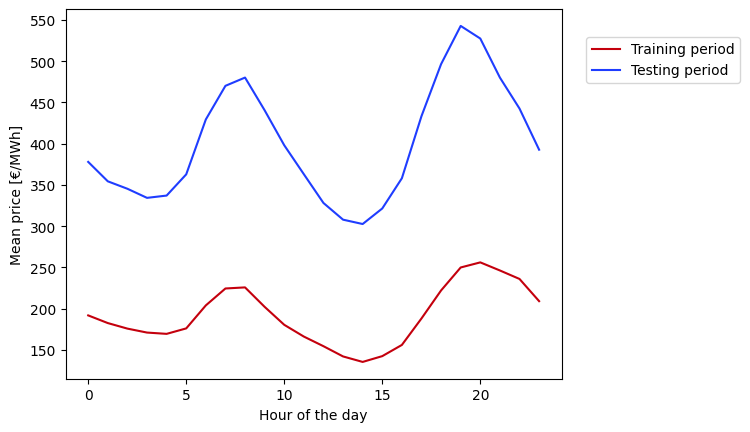

In [328]:

df_train = pd.DataFrame(separated_prices_days[0])
df_test = pd.DataFrame(separated_prices_days[1])
# lgd = ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5,-0.1))

xs = range(24)
f = plt.figure()
plt.plot(xs, df_train.mean(), label="Training period", color=red)
plt.plot(xs, df_test.mean(), label="Testing period", color=blue)
plt.xlabel("Hour of the day")
plt.ylabel("Mean price [€/MWh]")
lgd = plt.legend(loc=(1.05,0.8))
# plt.grid()
# plt.tight_layout()
plt.show()
f.savefig('mean_prices.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')


##### K-medoids clustering

In [375]:
#-------------K-medoids clustering--------------------
# Find k medoid days in each year
k = 3

# medoids is an array of depth (2(5(24)))
initial_medoids = [price_year[:k] for price_year in separated_prices_days]
final_medoids = []

for idx_period, f_prices in enumerate(separated_prices_days):
    data = np.array(separated_prices_days[idx_period])
    KMobj = KMedoids(n_clusters=k).fit(data)
    # labels = KMobj.labels_
    final_medoids.append(KMobj.cluster_centers_)



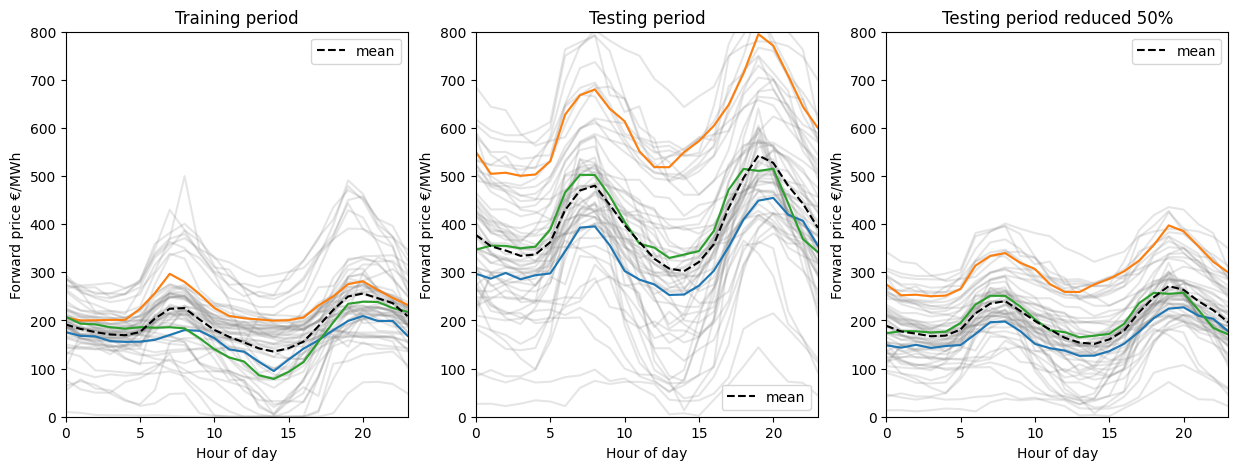

In [376]:
# ---------------Compare medoid days to each other
labels = ["Training period", "Testing period", "Testing period reduced 50%"]
dfs = [df_train, df_test, df_test]
## Plot for each year - good
fig, axs = plt.subplots(1, 3, figsize=(15,5))
for idx, (mlist, ax) in enumerate(zip([*final_medoids, final_medoids[-1]], axs)):
    ax.set_ylim([0, 800])
    ax.set_xlim([0, 23])
    f = 1
    pricedayidx = idx
    if idx == 2:
        f = 0.5
        pricedayidx = 1
    for p in separated_prices_days[pricedayidx]:
        ax.plot(range(24), p*f, "grey", alpha=0.2)
    for m in mlist:
        ax.plot(range(24), m*f)
    ax.plot(range(24), dfs[idx].mean()*f, 'k--', label="mean")
    ax.set_title(labels[idx])
    ax.set_ylabel("Forward price €/MWh")
    ax.set_xlabel("Hour of day")
    ax.legend()
plt.show()
# fig.savefig('k-medoids.pdf')


##### Reduced 2021

In [12]:
#----------Reduced 2021

fig, axs = plt.subplots(1, 3, figsize=(15,5))
for idx, (mlist, ax) in enumerate(zip(final_medoids, axs)):
    ax.set_ylim([0, 200])
    ax.set_xlim([0, 23])
    if idx != 2:
        for p in yearly_separated_prices_days[idx]:
            ax.plot(range(24), p, "grey", alpha=0.2)
        for m in mlist:
            ax.plot(range(24), m)
    else:
        for p in data_reduced:
            ax.plot(range(24), p, "grey", alpha=0.2)
        for m in reduced_2021_medoids:
            ax.plot(range(24), m)
    ax.set_title(f"Plot of {k} medoids for {labels[idx]}")
    ax.set_ylabel("Forward price €/MWh")
    ax.set_xlabel("Hour of day")
plt.show()
fig.savefig('k-medoids_2021_reduced.pdf')

##### In-depth statistic

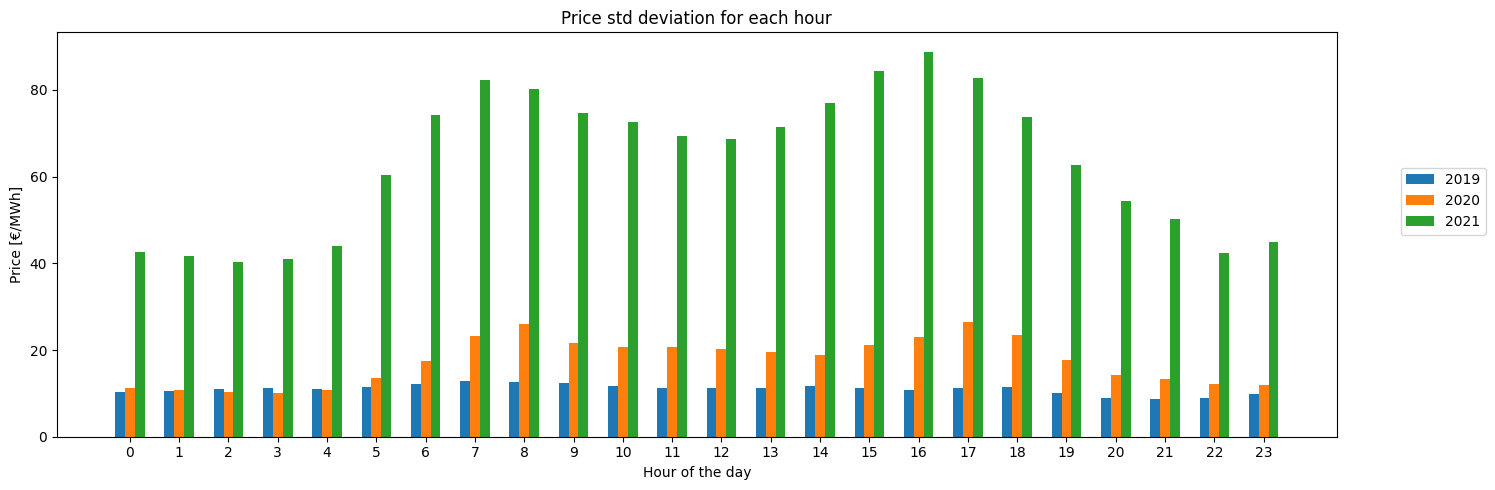

In [270]:
# df_2019.describe()
# df_2020.describe()
# df_2021.describe()


plotlabels = ['mean', 'std', 'min', '25%', '50%', '75%', 'max']
xlabels = range(24)
std_2019 = df_2019.std()
std_2020 = df_2020.std()
std_2021 = df_2021.std()

x = np.arange(len(xlabels))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 5))
rects1 = ax.bar(x - width, std_2019, width, label='2019')
rects2 = ax.bar(x, std_2020, width, label='2020')
rects2 = ax.bar(x + width, std_2021, width, label='2021')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Price [€/MWh]')
ax.set_xlabel('Hour of the day')
ax.set_title('Price std deviation for each hour')
ax.set_xticks(x, xlabels)
ax.legend(loc=(1.05,0.5))
fig.tight_layout()
plt.show()


In [18]:
#-----------------------------wasserstein distance calculation
from scipy.stats import wasserstein_distance

v_test = np.array([20-i for i in range(10)])
u_test = np.array([i for i in range(10)])

dist_matrix = np.empty((3,5,5))

all_medoids = [*final_medoids, reduced_2021_medoids]

mean_dists = {
    "2019-2020": 0,
    "2019-2021": 0,
    "2020-2021": 0,
    "2020-2021-red": 0,
    "2019-2021-red": 0,
    "2021-2021-red": 0,
    "2019-2019": 0,
    "2020-2020": 0,
    "2021-2021": 0,
    "2021-red-2021-red": 0
}


years_list = [[0, 1], [0, 2], [1, 2], [1, 3], [0, 3], [2, 3], [0, 0], [1, 1], [2, 2], [3,3]]

for i, key in enumerate(mean_dists.keys()):
    for from_idx in range(5):
        for to_idx in range(5):
            mean_dists[key] += wasserstein_distance(all_medoids[years_list[i][0]][from_idx], all_medoids[years_list[i][1]][to_idx])


mean_dists

# for y_idx in range(3):
#     for i in range(len(yearly_separated_prices_days[years_list[y_idx][0]])):
#         for j in range(len(yearly_separated_prices_days[years_list[y_idx][1]])):
            

{'2019-2020': 377.6045833333334,
 '2019-2021': 1146.2787500000002,
 '2020-2021': 1432.2016666666666,
 '2020-2021-red': 425.37000000000006,
 '2019-2021-red': 396.9585833333333,
 '2021-2021-red': 1349.8748333333333,
 '2019-2019': 135.005,
 '2020-2020': 354.4383333333333,
 '2021-2021': 1089.595,
 '2021-red-2021-red': 435.8380000000001}

## Detailed analysis of model output

In [434]:
# KMobj.medoid_indices_
len(prices_F)
df_det_ny = pd.read_csv("./results/2022/deterministic.csv")
df_det_ny.shape

(1440, 2)

In [428]:
# KMobj.medoid_indices_[0]*24
idx  = KMobj.medoid_indices_[0]*24
features.loc[offset+idx:offset+idx+23, "production_FC"]*10

2400    3.229389
2401    3.371517
2402    3.495013
2403    3.595169
2404    3.671316
2405    3.696695
2406    3.696695
2407    3.671316
2408    3.619859
2409    3.568403
2410    3.542325
2411    3.542325
2412    3.542325
2413    3.542325
2414    3.542325
2415    3.567705
2416    3.567705
2417    3.620567
2418    3.726308
2419    4.113133
2420    4.499958
2421    4.895892
2422    5.291827
2423    5.634899
Name: production_FC, dtype: float64

C:\Users\emilh\AppData\Local\Temp\ipykernel_11592\3392515033.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


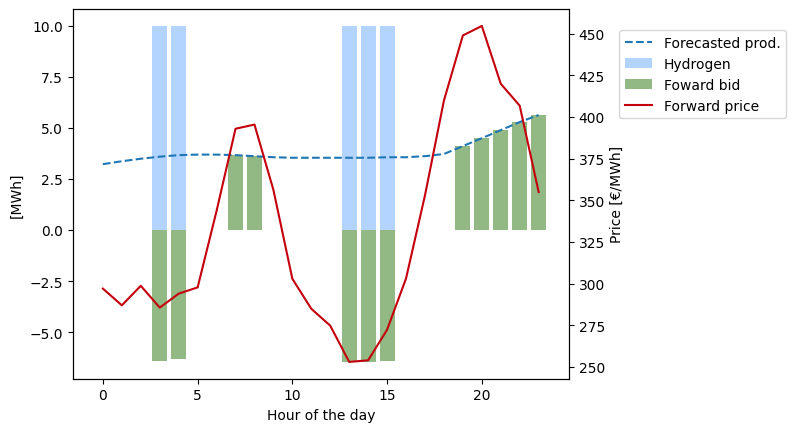

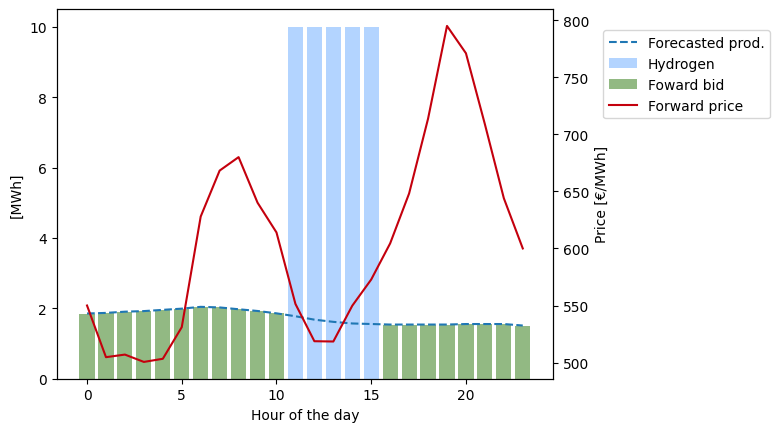

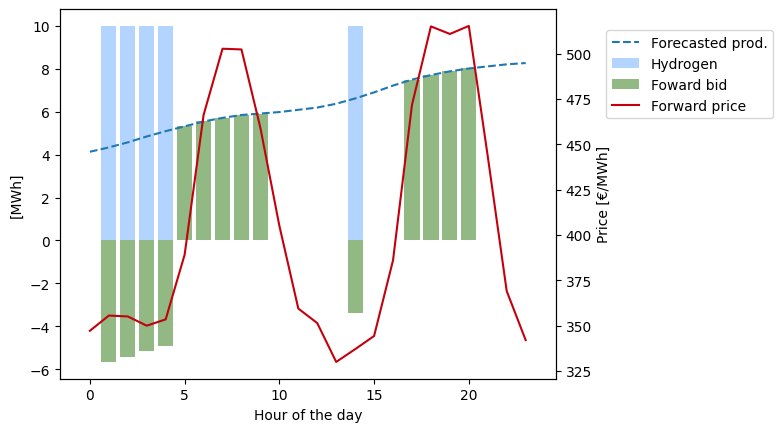

In [438]:


# KMobj.medoid_indices_ # [ 8, 21, 41]


offset = len(prices_F)-2*month
prices_F_test = prices_F[offset:]
prices_B_test = prices_B[offset:]
prices_S_test = prices_S[offset:]

def plot_res(res):
    for plotidx in range(3):
        prods_learned = np.empty(24)
        forward_learned = np.empty(24)
        idx = KMobj.medoid_indices_[plotidx]*24
        for i, t in enumerate(range(idx, idx+24)):
            h = i%24
            prods_learned[h] = res['h_prod'][t]
            forward_learned[h] = res['forward_bid'][t]
        fig, ax = plt.subplots()
        ax.bar(range(24), prods_learned, label="Hydrogen", color=cblue)
        ax.bar(range(24), forward_learned, label="Foward bid", color=cgreen)
        # ax.plot(range(24), realized[offset+idx:offset+idx+24], label="Realized prod.")
        ax.plot(range(24), features.loc[offset+idx:offset+idx+23, "production_FC"]*10, '--', label="Forecasted prod.")
        ax2 = ax.twinx()
        ax2.plot(range(24), prices_F_test[idx:idx+24], color=red, label="Forward price")
        # ax2.plot(range(24), prices_B_test[idx:idx+24], color=blue, label="Deficit price")
        # ax2.plot(range(24), prices_S_test[idx:idx+24], color=green, label="Surplus price")
        # fig.tight_layout()
        ax2.set_ylabel("Price [€/MWh]")
        ax.set_ylabel("[MWh]")
        ax.set_xlabel("Hour of the day")
        fig.legend(bbox_to_anchor=(1.25, 0.85))
        fig.show()

# plot_res(best_res)
plot_res(result_det_strict)
# plot_res(result_opt)



